In [17]:
from src.paths import LOCAL_RAW_DATA_PATH, LOCAL_PROCESSED_DATA_PATH, LOCAL_MODELS_PATH


from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from tqdm._tqdm_notebook import tqdm_notebook
from collections import OrderedDict
from xgboost import plot_importance
import matplotlib.pyplot as plt 
from scipy.stats import skew
import missingno as msno
import pandas as pd
import xgboost
import pickle


tqdm_notebook.pandas()

seed = 42

df_path = LOCAL_PROCESSED_DATA_PATH / 'pretrain_dataset_20211013.pkl'
df = pd.read_pickle(df_path)
tgt_vars = [c for c in df.columns if '_change_' in str(c)]

drop_cols = ['created_at', 'created_at_trunc_h', 'id_str',
             'full_text', 'user_screen_name',
             'ma_120_periods', 'ma_720_periods'] + tgt_vars

X_cols = [c for c in df.columns if c not in drop_cols]

In [18]:
df['close_change_2periods_perc_3Q'] = pd.qcut(df['close_change_2periods_perc'], q=3)
cc1pp3Q_to_hr = {}
scale = ['DECREASE', 'NEUTRAL', 'INCREASE']
for i, v in enumerate(df['close_change_2periods_perc_3Q'].unique().sort_values()):
    cc1pp3Q_to_hr[v] = f'Q{i+1}_{scale[i]}' 
cc1pp3Q_to_hr

{Interval(-0.136, -0.00304, closed='right'): 'Q1_DECREASE',
 Interval(-0.00304, 0.0034, closed='right'): 'Q2_NEUTRAL',
 Interval(0.0034, 0.146, closed='right'): 'Q3_INCREASE'}

In [19]:
df['close_change_2periods_perc_3Q_HR'] = df['close_change_2periods_perc_3Q'].map(cc1pp3Q_to_hr)

In [45]:
# df[['close_change_2periods_perc_3Q_HR', 'close_change_2periods_perc_3Q', 'close_change_2periods_perc', 'close']]

In [20]:
X = df[X_cols]
y = df['close_change_2periods_perc_3Q_HR']

In [21]:
X.isna().sum().sum(), y.isna().sum()

(0, 0)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=seed)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=seed) 

In [23]:
print(X_train.shape,  X_test.shape)
print(y_train.shape,  y_test.shape)
df.shape[0] == X_train.shape[0] + X_test.shape[0] 

(73656, 779) (18415, 779)
(73656,) (18415,)


True

In [24]:
# xgboost.XGBClassifier
# xgboost.XGBRFClassifier

In [25]:
xgboost.set_config(**{'use_rmm': False, 'verbosity': 1})

In [26]:
%time

model = xgboost.XGBRFClassifier(**{
    'colsample_bytree': 0.8,
    'gamma': 0,
    'learning_rate': 0.01,
    'max_depth': 5,
    'min_child_weight': 1.5,
    'n_estimators': 1200,
    'reg_alpha': 0.75,
    'reg_lambda': 0.45,
    'seed': seed,
    'subsample': 0.9
}) 


model.fit(X_train,y_train)

Wall time: 0 ns


c:\users\muril\.virtualenvs\crypto-prophet-ckjwbuny\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[02:49:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bytree=0.8, gamma=0, gpu_id=-1,
                importance_type='gain', interaction_constraints='',
                learning_rate=0.01, max_delta_step=0, max_depth=5,
                min_child_weight=1.5, missing=nan, monotone_constraints='()',
                n_estimators=1200, n_jobs=8, num_parallel_tree=1200,
                objective='multi:softprob', random_state=42, reg_alpha=0.75,
                reg_lambda=0.45, scale_pos_weight=None, seed=42, subsample=0.9,
                tree_method='exact', validate_parameters=1, verbosity=None)

In [27]:
with open(LOCAL_MODELS_PATH / 'xgboost_20211014_XGBRFClassifier_3Q2H.pkl', mode='wb') as fp:
    pickle.dump(model, fp)

In [28]:
print('finish!')

finish!


In [29]:
from sklearn.metrics import accuracy_score
accuracy_score(y, model.predict(X))

0.5109100585417775

In [37]:
accuracy_score(y_test, model.predict(X_test))

0.5044800434428455

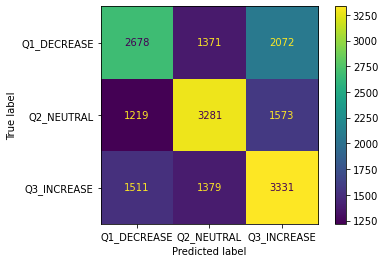

In [30]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(model, X_test, y_test)  

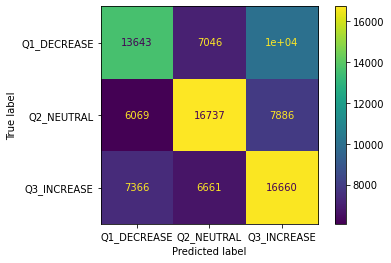

In [31]:
plot_confusion_matrix(model, X, y)  

In [32]:
import pickle

In [33]:
with open(LOCAL_MODELS_PATH / 'user_label_encoder.pkl', 'rb') as fp:
    user_le = pickle.load(fp)

In [34]:
user2score = []
for u in X_train.user_feat.unique():
    mask = X.user_feat == u
    user_screen_name = user_le.inverse_transform([u])[0]
    stats ={
        'user_label': u,
        'user_screen_name': user_screen_name,
        'accuracy': model.score(X[mask], y[mask]),
        'tweet_count': mask.sum()}
    user2score.append(stats)
user2score = pd.DataFrame(user2score).sort_values('accuracy', ascending=False)

In [35]:
user2score

,user_label,user_screen_name,accuracy,tweet_count
31,19,PeterMcCormack,0.620679,3240
14,41,officialmcafee,0.615456,3235
15,28,VitalikButerin,0.598872,3191
7,15,IvanOnTech,0.568035,3410
6,17,LayahHeilpern,0.564079,3246
21,42,rogerkver,0.556522,575
16,35,elonmusk,0.554217,3237
37,14,FEhrsam,0.548961,337
3,39,justinsuntron,0.542572,3406
8,32,coinbureau,0.533278,2419
